In [6]:
#imports (same as tuto ML)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder # is this really needed ?
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV, PredefinedSplit

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline

# Question 1: Propensity score matching

We preform a naive data analysis using plots and numbers.

In [82]:
#import the data set
lalonde_df = pd.read_csv('lalonde.csv')
#give a first look
lalonde_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

We assume that a naive researcher unfamiliar with observational studies would treat the data as if it was a randomized trial, not taking into consideration the hidden correlates.

We can easily imagine that the first thing he would do is split the salary (_['re78']_) data into 2 sets: treated and untreated.

In [8]:
#masks to be used alot later
treated = (lambda x: x.treat == 1)
untreated = (lambda x: x.treat == 0)

#apply masks to get treated and untreated
treated_salary = lalonde_df[treated(lalonde_df)]['re78']
untreated_salary = lalonde_df[untreated(lalonde_df)]['re78']

**i - Visualizing the data:**

We first plot the final salary data in a histogram to find the distribution of salaries between the two groups.

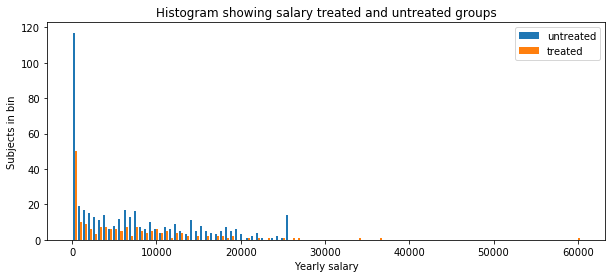

In [9]:
plt.figure(figsize=(10, 4))
plt.hist([untreated_salary, treated_salary], bins=100)
plt.title('Histogram showing salary treated and untreated groups')
plt.legend(['untreated', 'treated'])
plt.xlabel('Yearly salary')
plt.ylabel('Subjects in bin')
plt.show()

##### First insights:

By looking at the graph, we see a very similar distribution for both functions, except that outliers are present in the treated group.

Another very visible element is the fact that the function of the treated group's salaries is shifted to the bottom. Very quickly (cf paragraph below), a simple explanation arises: the number of members in the treated group is lower.

**ii - Describing the numbers**

Thus, we determined that he would only look at the basic descriptions of the data (mean, std and 5 number summary). 

In [10]:
lalonde_df.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,6984.169742,7294.161791,0.0,220.1813,4975.505,11688.820,25564.67
1,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


From the numbers above, we assume that the research would extract the following information from the data :

- The untreated group has more people.
- The untreated group's salaries are higher (higher mean).
- However, the max salary in the treated group is 3x higher! The 1st quartile is also twice higher on the treated group.
- Finally, we have that the second and third quartiles are higher in the first group. Quartiles are more resistent to outliers, so we should put more consideration
- The interquartile distance is larger in the untreated set, as we have outliers in the set this is a better measure for 'variance'.

**iii - Boxplot:**

A boxplot will illustrate the above more consciely

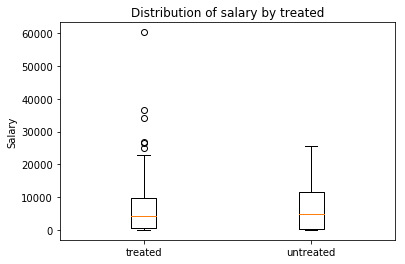

In [11]:
plt.boxplot([treated_salary, untreated_salary], labels=['treated', 'untreated'])
plt.title('Distribution of salary by treated')
plt.ylabel('Salary')
plt.show()

**Conclusion**:

By merging all of the insights the researcher has drawn from the 3 steps of his analysis, he can conclude that **the treatment is ineffective**. Even though salary distributions are similar in both cases, the treated group has in average a lower salary (and only a handful of rich people get lucky). This is shown by the boxplot: the whiskers extend higher in the untreated group.

### 2. A closer look at the data

After performing a **simplistic** analysis of the data ignoring underlying factors –such as race and education– that could influence the outcome, we start looking at the whole table assuming the other features will impact _['re78']_.

**i - Categorical data :**

Regarding categorical data, we should look at rates (makes much more sense than looking at just the numbers). Thus we define the rates for race, degree and mariage depending on each treatment to be able to compare them.

In [15]:
#as the values are binary the mean is equal to the percentage of occurence
percentages = lalonde_df.groupby('treat').mean()
percentages

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530


##### a. Race ratios:

We will start with race. As we do not have numbers for "White" participants, we get the number of "Blacks" and "Hispanics" for each treatment group and substract the total. We then compare the rates of each race using pie charts.

In [16]:
black_u, black_t = percentages['black']
hispan_u, hispan_t = percentages['hispan']
#there is no overlap in the hispan and black categories, 
#we assume people that are neither are white (which we checked, it is the case)
white_u, white_t = (1 - black_u - hispan_u, 1 - black_t - hispan_t)

In [17]:
u_race_rates = [black_u, hispan_u, white_u]
t_race_rates = [black_t, hispan_t, white_t]
#give name to lable
race_labels = 'Black', 'Hispanic', 'White'

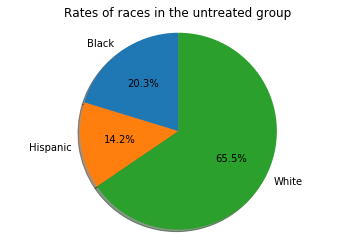

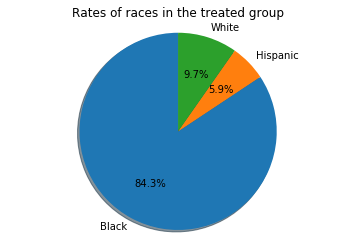

In [18]:
plt.pie(u_race_rates, labels = race_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rates of races in the untreated group")
plt.show()

plt.figure()

plt.pie(t_race_rates, labels = race_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rates of races in the treated group")
plt.show()

We see that there are way more black subjects in the treatment group than in the untreated group.

##### b. Degree ratios:

To have a better understanding of the difference of salaries, we also need to look at the level of education of the participants of each treatment.

In [19]:
nodegree_u, nodegree_t = percentages['nodegree']
degree_u, degree_t = (1 - nodegree_u, 1 - nodegree_t)

In [20]:
#calculate rate for degree havers in treated and untreated group
u_degree_rates = [1 - nodegree_u, nodegree_u]
t_degree_rates = [1 - degree_t, nodegree_t]
degree_labels = 'Degree', 'No degree'

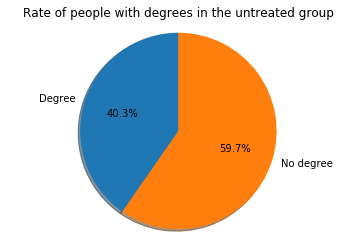

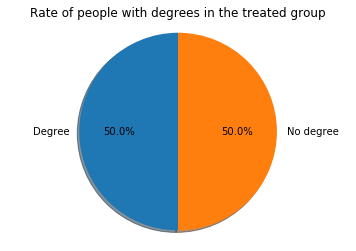

In [21]:
#draw pie diagram
plt.pie(u_degree_rates, labels = degree_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rate of people with degrees in the untreated group")
plt.show()
plt.figure()
plt.pie(t_degree_rates, labels = degree_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rate of people with degrees in the treated group")
plt.show()

We see that the treated group is less educated, by a difference of over 10%

##### c. Marriage ratios:

Finally, we look at the rates of married people among both groups as it is our last feature. 

In [22]:
#married and unmarried by treatment
married_u, married_t = percentages['married']
not_married_u, not_married_t = (1 - married_u, 1 - married_t)

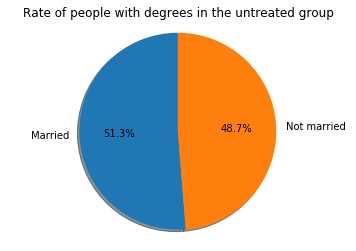

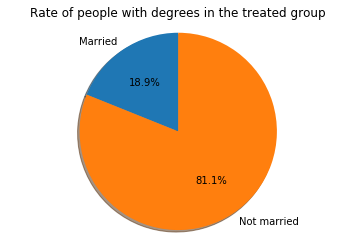

In [23]:
mariage_labels = 'Married', 'Not married'
#untreated group
plt.pie([married_u, not_married_u], labels = mariage_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rate of people with degrees in the untreated group")
#treated group
plt.figure()
plt.pie([married_t, not_married_t], labels = mariage_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rate of people with degrees in the treated group")
plt.show()

We again note that the treated group contains less married individuals.
Marriage can be an indicator of stability and thus indicate how likely somebody is to preform consistenly well on job.

##### d. Unemployment ratios:

Even though salaries are not categories but intervals, it is important to compare unemployment rates between both groups (which we define at categories). To get better insights, we will plot the evolution between 1974 and 1978.

          id  treat  age  educ  black  hispan  married  nodegree  re74  re75  \
0       NSW1      1   37    11      1       0        1         1   0.0   0.0   
1       NSW2      1   22     9      0       1        0         1   0.0   0.0   
2       NSW3      1   30    12      1       0        0         0   0.0   0.0   
3       NSW4      1   27    11      1       0        0         1   0.0   0.0   
4       NSW5      1   33     8      1       0        0         1   0.0   0.0   
5       NSW6      1   22     9      1       0        0         1   0.0   0.0   
6       NSW7      1   23    12      1       0        0         0   0.0   0.0   
7       NSW8      1   32    11      1       0        0         1   0.0   0.0   
8       NSW9      1   22    16      1       0        0         0   0.0   0.0   
9      NSW10      1   33    12      0       0        1         0   0.0   0.0   
10     NSW11      1   19     9      1       0        0         1   0.0   0.0   
11     NSW12      1   21    13      1   

/Users/othmanben/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/othmanben/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: setting an array element with a sequence.

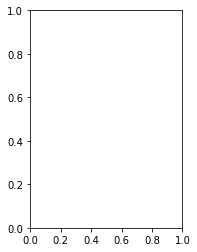

In [107]:
#defining list of non binary variables
salaries = ['re74', 're75', 're78']
cat_salaries = lalonde_df.copy()

#for each column draw a Boxplot
for sal in salaries:
    cat_salaries[cat_salaries[sal] > 0][sal] = 1
    cat_salaries[cat_salaries[sal] == 0][sal] = 0
    print(cat_salaries)
    
    job_u, job_t = lalonde_df[lalonde_df.nodegree == 0].groupby('treat')[sal].count()
    no_job_u, no_job_t = (1 - job_u, 1 - job_t)
    degree_labels = 'Employed', 'Unemployed'
    
    plt.subplot(1, 2, 1)
    plt.pie([job_u, nojob_u], labels = degree_labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.set_title("Rate of unemployed people in 19" + sal[-2:])
    plt.subplot(1, 2, 2)
    plt.pie([job_t, nojob_t], labels = degree_labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.set_title("Rate of unemployed people in 19" + sal[-2:])
    plt.show()

In [19]:
nojob_u, nojob_t = percentages['nodegree']
job_u, job_t = (1 - nojob_u, 1 - nojob_t)

In [20]:
#calculate rate for degree havers in treated and untreated group
u_degree_rates = [1 - nodegree_u, nodegree_u]
t_degree_rates = [1 - degree_t, nodegree_t]
degree_labels = 'Degree', 'No degree'

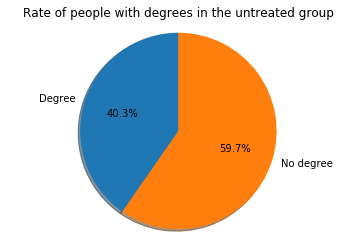

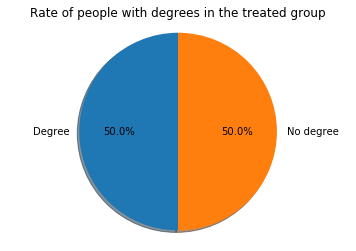

In [21]:
#draw pie diagram
plt.pie(u_degree_rates, labels = degree_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rate of people with degrees in the untreated group")
plt.show()
plt.figure()
plt.pie(t_degree_rates, labels = degree_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Rate of people with degrees in the treated group")
plt.show()

We see that the treated group is less educated, by a difference of over 10%

**Conclusion:**

By looking at the categorical data, we can say that the underlying factors between the two groups are not similar.
The treated group is significantly more black, less educated and married. All these factors influence employment and should be taken into consideration.

**ii - Interval data :**

We start our analysis by visualizing the data to see if the two groups have different underlying distrubutions of factors. We split out analysis in by **categorical** and **intervall** data. In the beginning, we will focus on the latter.

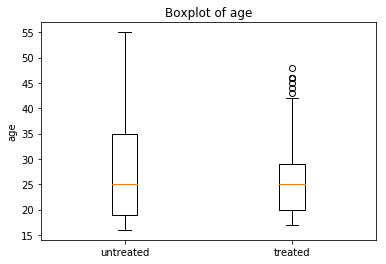

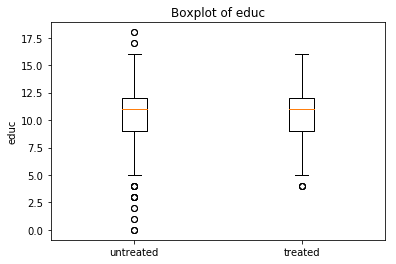

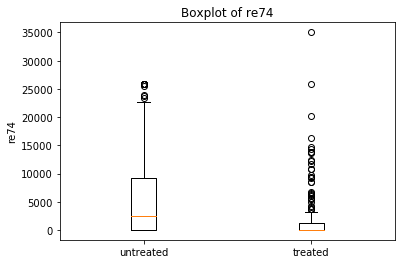

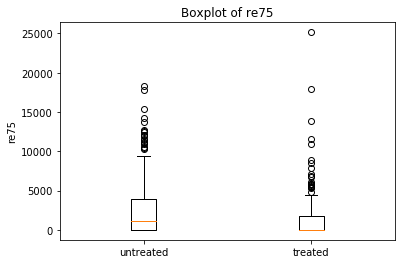

In [12]:
#defining list of non binary variables
intervals = ['age', 'educ', 're74', 're75']

#for each column draw a Boxplot
for col in intervals:
    plt.title("Boxplot of " + col)
    plt.boxplot([lalonde_df[untreated(lalonde_df)][col], lalonde_df[treated(lalonde_df)][col]], 
                labels=['untreated', 'treated'])
    plt.ylabel(col)
    plt.figure()

\NOT RIGHT REPLACE From the graphs above, we can see very clearly 2 elements. First, the data distribution is always similar between the 2 groups (even though the number of participants is different due to the difference in the number of people in both groups). On top of this, 3 types of distributions pop out:
- Poisson: this is the distribution representing the **age** of participants <- rly??? that's not what I'm seeing
- Gaussian : this distribution models the **level of education** of participants
- Power law : this type of distribution is appropriate to understand the **salaries** of participants (_['re74'], ['re75'] and ['re78']_ all have the same form of distribution)

##### a. Salaries:

The main thing we need to look at is the salaries with respect to the education. Education likely influences the salary

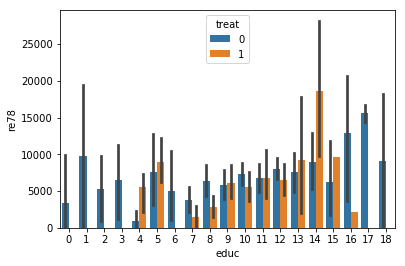

In [13]:
plt.figure()
sns.barplot(y="re78", x='educ', data=lalonde_df, hue='treat')

##### b. Evolution:

Even though it is useful to plot the salaries to see the difference between the years, it is much more useful to understand how the salary of each participant has changed over the years. To do so, we will visualize our data using a parallel plot. 

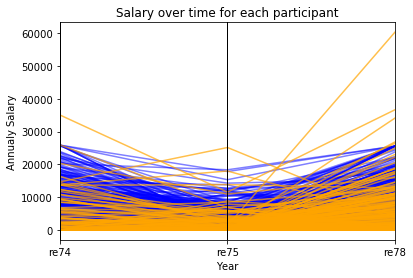

In [14]:
#Implement parallel plot
from pandas.plotting import parallel_coordinates
parallel_coordinates(lalonde_df[untreated(lalonde_df)][['id','re74', 're75', 're78']], 'id', color='Blue', alpha=0.5)
parplot = parallel_coordinates(lalonde_df[treated(lalonde_df)][['id','re74', 're75', 're78']], 'id', color='Orange' , alpha=0.7)
#remove legend for readability
parplot.legend_.remove()
plt.title('Salary over time for each participant')
plt.xlabel('Year')
plt.ylabel('Annualy Salary')

We see that:
- the treated group started out with a lower salary
- 75 was a bad year for everybody, treated or untreated.
- the outliers are people partialy people who were already well payed in 74, partialy people who 'made it'.
- there is a lot of movement up for the treated group between 75 and 78

**Conclusion:**

By looking at the interval data, and more specificaly at the salaries of participants, we can say that …

**iii - Correlated data :**

After working on each value alone, we want to understand how each value is (linearly) linked to others on each pair of features. We look at the pairplot, as correlation by itself does not give us any insights, as clearly the data is not linearly dependent.

We note that we can somewhat seperate the two groups, inicating that they ate not the same

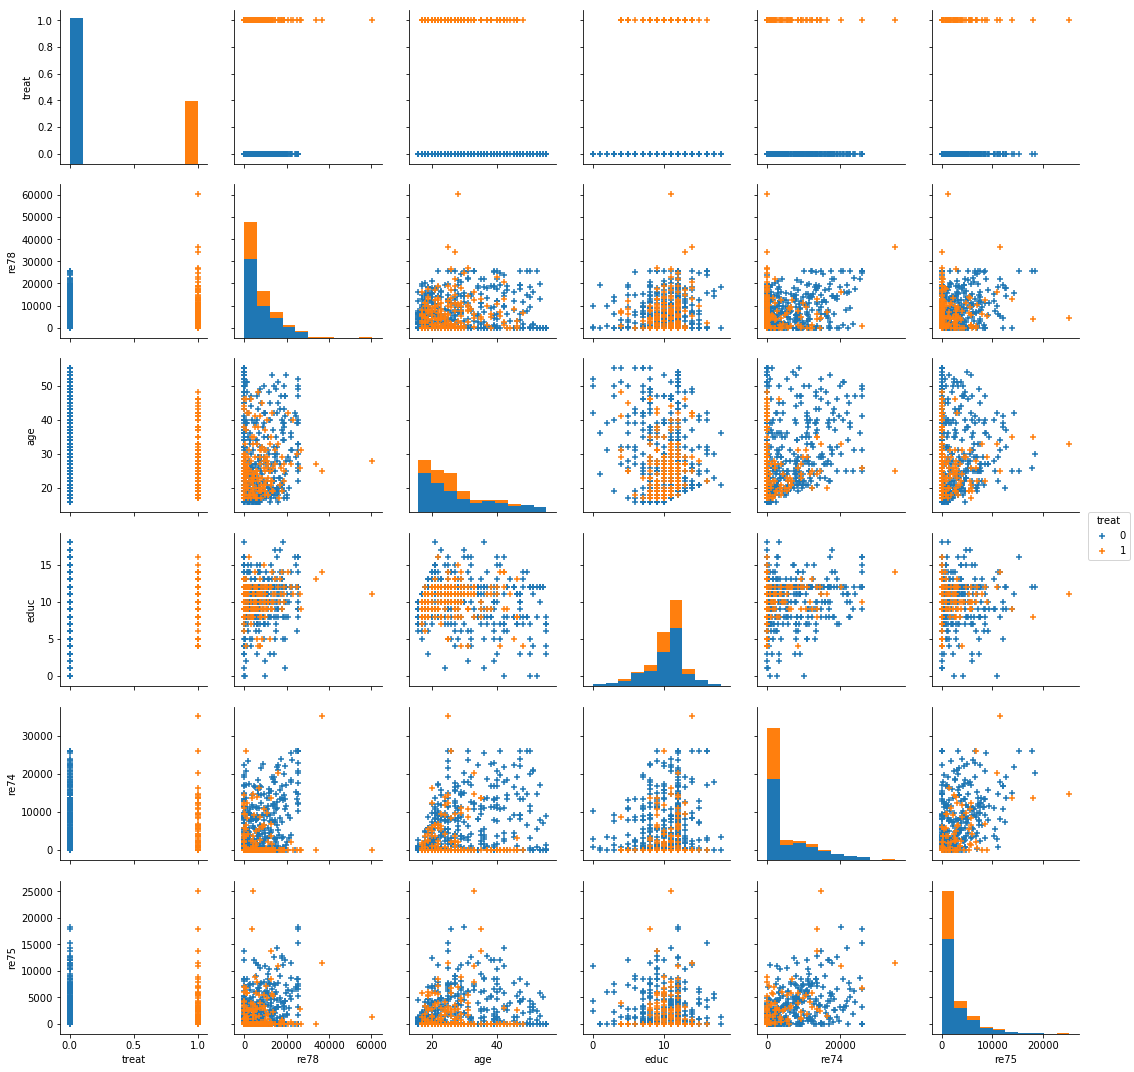

In [24]:
sns.pairplot(lalonde_df[['treat', 're78']+intervals], markers='+', hue='treat')

### 3. A propsensity score model

The create a fair set to use on our observational study, we calculate the propensity score based on the underlying factors before treatment:

[age, educ, hispan, black, nodegree, re74, re75]

**note: we consider all these factors to have been recorded before treatment**

In [25]:
prop_table = lalonde_df.copy() #otherwise we modify lalonde_df when we modify prop_table

In [26]:
#create our target and training data:

X = prop_table.iloc[:, 2:-1] #rows age to 're75'
y = prop_table.iloc[:, 1:2] #treated or not
y = np.ravel(y) #flatten array
print('First elements of Y : \n', y[0:5],'\nFirst elements of X\n', X[0:5])

First elements of Y : 
 [1 1 1 1 1] 
First elements of X
    age  educ  black  hispan  married  nodegree  re74  re75
0   37    11      1       0        1         1   0.0   0.0
1   22     9      0       1        0         1   0.0   0.0
2   30    12      1       0        0         0   0.0   0.0
3   27    11      1       0        0         1   0.0   0.0
4   33     8      1       0        0         1   0.0   0.0


In [27]:
#define our model
logistic = LogisticRegression()
logistic.fit(X, y)
print('Accuracy of prediction: ',logistic.score(X, y))

Accuracy of prediction:  0.807817589577


In [28]:
print("Example of prediction : ", logistic.predict(X[0:6]), ' reality :', y[0:6])
print('Example of prediction in percent : \n', logistic.predict_proba(X[0:6]))

Example of prediction :  [0 0 1 1 1 1]  reality : [1 1 1 1 1 1]
Example of prediction in percent : 
 [[ 0.55664958  0.44335042]
 [ 0.85534047  0.14465953]
 [ 0.27764537  0.72235463]
 [ 0.33584948  0.66415052]
 [ 0.30171439  0.69828561]
 [ 0.29988169  0.70011831]]


In [29]:
#get propensity scores, probability of "being a subject"
prop_table['propensity_scores'] = pd.Series(logistic.predict_proba(X)[:,1])

In [30]:
prop_table.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_scores
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


We now use the propensity scores to find a matching.

### 4. Balancing the dataset via matching

Matching the two is an equivalent problem to find a matching in a bipartite graph

In [31]:
import networkx as nx
B = nx.Graph()
#1. Creat graph with nodes as id
B.add_nodes_from(prop_table['id'])

In [32]:
# 2. Add edges from each treated to each untreated subject
#    with weight on each node being the difference between the two
for row_i in prop_table[treated(prop_table)].iterrows():
    for row_j in prop_table[untreated(prop_table)].iterrows():
        B.add_edge(row_i[1]['id'],row_j[1]['id'], 
                   #-x to transform minimisation problem into maximisation problem
                   weight= 1 - np.abs(row_i[1].propensity_scores - row_j[1].propensity_scores))

In [33]:
#3. Find matching
matching_dict = nx.max_weight_matching(B)

In [34]:
print('Example matches:')
list(matching_dict.items())[:5]

Example matches:


[('PSID184', 'NSW135'),
 ('NSW98', 'PSID399'),
 ('NSW84', 'PSID268'),
 ('NSW35', 'PSID398'),
 ('NSW174', 'PSID367')]

In [35]:
#get matching
remaning_subjects = prop_table.copy()[prop_table['id'].isin(matching_dict)]
print('we have : ',len(remaning_subjects)/2, ' matched subjects') #pairs appear in 2 order s ab and ba

we have :  185.0  matched subjects


In [36]:
#separate treated and untreated
remaning_subjects.groupby('treat').mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_scores
treat,,,,,,,,,,
0,23.713514,10.162162,0.470270,0.118919,0.167568,0.627027,2095.885961,1615.306428,5312.474907,0.371066
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.561869


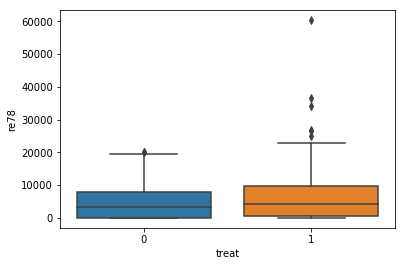

In [37]:
sns.boxplot(data=remaning_subjects, x='treat', y='re78') # this one is similar! good!

In [38]:
remaning_subjects[remaning_subjects['black'] == 1].groupby('treat')['id'].count() #unbalanced

treat
0     87
1    156
Name: id, dtype: int64

In [39]:
remaning_subjects[remaning_subjects['hispan'] == 1].groupby('treat')['id'].count()

treat
0    22
1    11
Name: id, dtype: int64

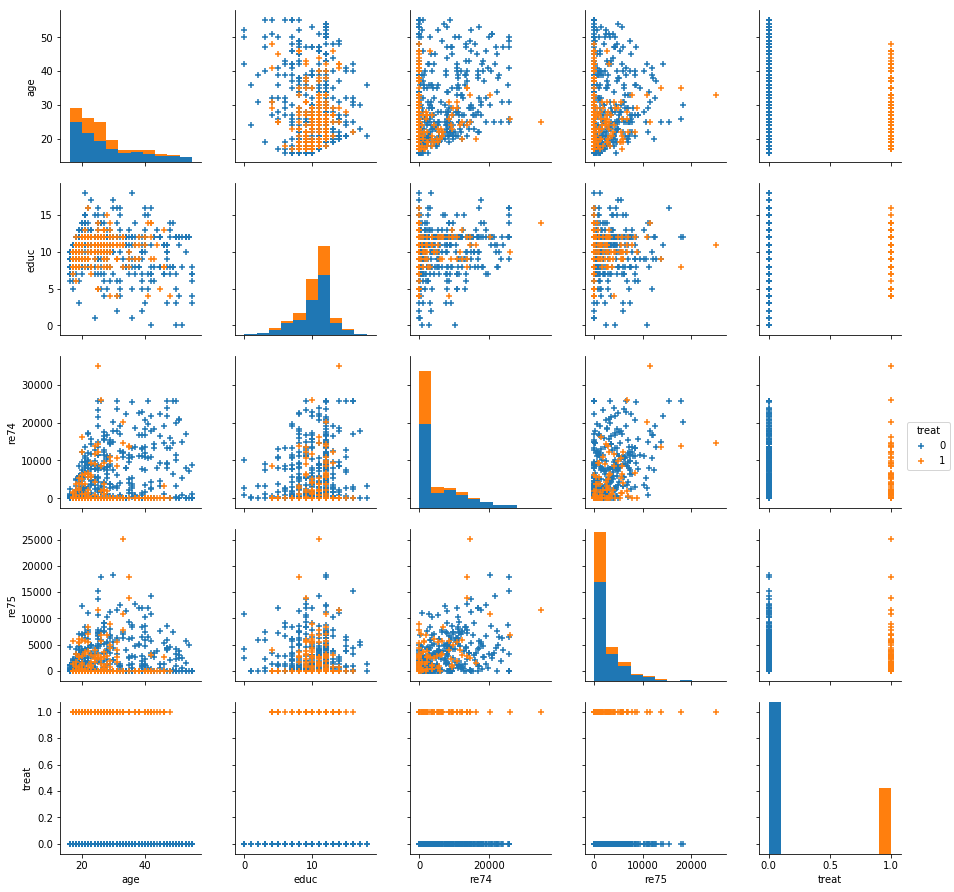

In [40]:
sns.pairplot(prop_table[intervals+['treat']], markers='+', hue='treat')

### 5. Balancing the groups further


We note that there are still way more black subjects in the treated group than in the untreated group.
Additionaly, we still have outliers in the treated group.

We try to balance the both groups by removing white subjects matched with outlying black subjects

In [41]:
remaning_subjects['match'] = remaning_subjects['id'].map(matching_dict)

In [42]:
remaning_subjects.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_scores,match
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,PSID219
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,PSID395
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,PSID97
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151,PSID17
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,PSID380


In [43]:
matches = remaning_subjects[treated(remaning_subjects)].merge(remaning_subjects[untreated(remaning_subjects)], left_on='id', right_on='match')

In [44]:
matches.head()

,id_x,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,...,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y,propensity_scores_y,match_y
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,...,7,0,0,0,1,0.000,975.7258,4728.725,0.181317,NSW1
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,...,12,0,0,0,0,0.000,0.0000,0.000,0.143760,NSW2
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,...,12,1,0,1,0,8573.752,4293.1940,0.000,0.439327,NSW3
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,...,9,0,1,0,1,5460.477,10589.7600,7539.361,0.168062,NSW4
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,...,12,1,0,1,0,0.000,0.0000,18716.880,0.521865,NSW5


In [45]:
matches['difference'] = abs(matches['propensity_scores_x'] - matches['propensity_scores_y'])

In [46]:
#matches that are black/white missmatched and have a large difference in propensity scores
to_drop = matches[(matches['black_x'] == 1) & (matches['black_y'] == 0) & (matches['hispan_y'] == 0) & (matches.difference > .5)].index

In [47]:
final_matches = matches.drop(to_drop)

In [48]:
final_matches.groupby('black_x')['id_x'].count() #treated

black_x
0     29
1    138
Name: id_x, dtype: int64

In [49]:
final_matches.groupby('black_y')['id_y'].count() #untreated

black_y
0    80
1    87
Name: id_y, dtype: int64

In [50]:
final_matches.mean()

treat_x                   1.000000
age_x                    25.952096
educ_x                   10.359281
black_x                   0.826347
hispan_x                  0.065868
married_x                 0.209581
nodegree_x                0.688623
re74_x                 2150.573623
re75_x                 1591.537003
re78_x                 6306.093543
propensity_scores_x       0.549778
treat_y                   0.000000
age_y                    23.640719
educ_y                   10.113772
black_y                   0.520958
hispan_y                  0.131737
married_y                 0.185629
nodegree_y                0.634731
re74_y                 2240.005114
re75_y                 1684.050292
re78_y                 5416.000552
propensity_scores_y       0.394397
difference                0.156067
dtype: float64

In [55]:
#removing outliers
nana = final_matches.drop(final_matches[final_matches.re78_x > 30000].index)

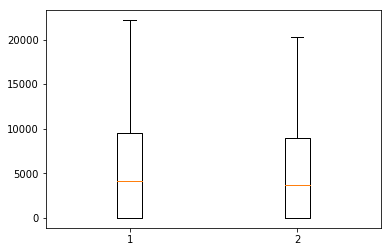

In [56]:
plt.boxplot([nana['re78_x'], nana['re78_y']])
plt.show()

In [57]:
nana.re78_x.describe()

count      161.00000
mean      5473.70473
std       5510.73510
min          0.00000
25%          0.00000
50%       4146.60300
75%       9558.50100
max      22163.25000
Name: re78_x, dtype: float64

In [58]:
nana.re78_y.describe()

count      161.000000
mean      5530.322788
std       6012.874283
min          0.000000
25%          0.000000
50%       3683.972000
75%       8923.991000
max      20243.380000
Name: re78_y, dtype: float64

### 6. A less naive analysis

After controlling for unerlying factors we see that the treated population fares better than the untreated population

# Question 2: Applied ML

First, we need to compute the TF-IDF features of our dataset, using a vectorizer. As we understood the question, what was asked was not to use any of the given datasets from sklearn, but to use all of the data. Thus, we do not use the train and test subsets given to us in sklearn, but will create our own such subsets, adding a validation subset.

Also note that we remove the headers, footers and quotes, as proposed in the <a href="http://scikit-learn.org/stable/datasets/twenty_newsgroups.html">sklearn tutorial</a> of the dataset, as to have something more realistic and without any of the metadata. Note also that we did not use the *sklearn.datasets.fetch_20newsgroups_vectorized* function that returns the TF-IDF features directly, as it would defeat the purpose of the exercise.

In [ ]:
# create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

In [ ]:
# Import the data we need to use the vectorizer on. Remove metadata as proposed by sci-kit tutorial
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

As asked in the question, before seperating in subsets, we will use the vectorizer on the complete set.

In [ ]:
# vectors is a sparse matrix
vectors = tfidf.fit_transform(newsgroups_all.data)

Now we need to seperate the dataset into three sets: train, test and validation.

In [ ]:
# first we seperate train from the rest. Random_state given to have a seed.
newsgroups_train, newsgroups_inter, vect_train, vect_inter = \
    train_test_split(newsgroups_all.target, vectors, test_size=0.2, random_state=1)

# then we seperate again to get validation and test seperately
newsgroups_test, newsgroups_valid, vect_test, vect_valid = \
    train_test_split(newsgroups_inter, vect_inter, test_size=0.5, random_state=1)

## 2.

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.


Now we need to train a random forest on our training set. For this, we will use the RandomForestClassifier, as it contains the parameters talked about in the exercise. But first, we need to ask ourselves what we want to set the parameters (*max_depth* and *n_estimators*) to.

According to the ADA course, we know that the number of trees will be in the 10's and the depth will be betweem 20 to 30. Thus for the training set, we set *n_estimators* to 10 and *max_depth* to 25.

For the predictions, we can't use the training set, as we just trained on it and thus would get very good results regardless. So prediction has to be on the validation set.

In [ ]:
# need to find estimators and depth first. We use random_state to have a seed again.
clf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=1)
clf.fit(vect_train, newsgroups_train)
pred = clf.predict(vect_valid)
metrics.f1_score(newsgroups_valid, pred, average='macro')

As we can see, predictions aren't that great.

We try to fine tune on the validation set. Note that to do this, we usethe GridSearch implemented in sklearn. We first chose he estimators between 100 and 1000 and a depth between 20 and 30 as it is what we have seen during the lessons, but seeing as the results for the best parameters were the upper limit (30 and 1000) we decided to look if it would still be the same by taking a larger upper limit (35 and 1500).

Also, as we have already our own training, validation and test sets, we need to use *PredefinedSplit* in the GridSearch.

Please note that the fit takes a lot of time to compute, as there are a very large numbers of estimators.

In [ ]:
param_grid = { 
    'n_estimators': [1000],
    'max_depth': [250, 500]
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1)

In [ ]:
CV_rfc.fit(vect_valid, newsgroups_valid)

In [ ]:
print(CV_rfc.best_params_)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=250, random_state=1, n_jobs=-1)
clf.fit(vect_train, newsgroups_train)
pred = clf.predict(vect_valid)
metrics.f1_score(newsgroups_valid, pred, average='macro')

As we can see, te best resuts are when *n_estimators* is set around X and *max_depth* is set to X. 

Now we do a confusion matrix on the test set.

Now, let us inspect the `feature_importances_` attribute of our random forest.